In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
df = pd.read_csv('churn-bigml-20.csv')
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,WI,114,415,No,Yes,26,137.1,88,23.31,155.7,125,13.23,247.6,94,11.14,11.5,7,3.11,2,False
663,AL,106,408,No,Yes,29,83.6,131,14.21,203.9,131,17.33,229.5,73,10.33,8.1,3,2.19,1,False
664,VT,60,415,No,No,0,193.9,118,32.96,85.0,110,7.23,210.1,134,9.45,13.2,8,3.56,3,False
665,WV,159,415,No,No,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1,False


In [4]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())
print("\nTarget variable distribution:")
print(df['Churn'].value_counts())

Dataset Shape: (667, 20)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  To

In [5]:
categorical_cols = ['State', 'International plan', 'Voice mail plan']
le = LabelEncoder()

for col in categorical_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

In [6]:
df['Churn'] = df['Churn'].astype(int)

In [7]:
X = df.drop('Churn', axis=1)
y = df['Churn']

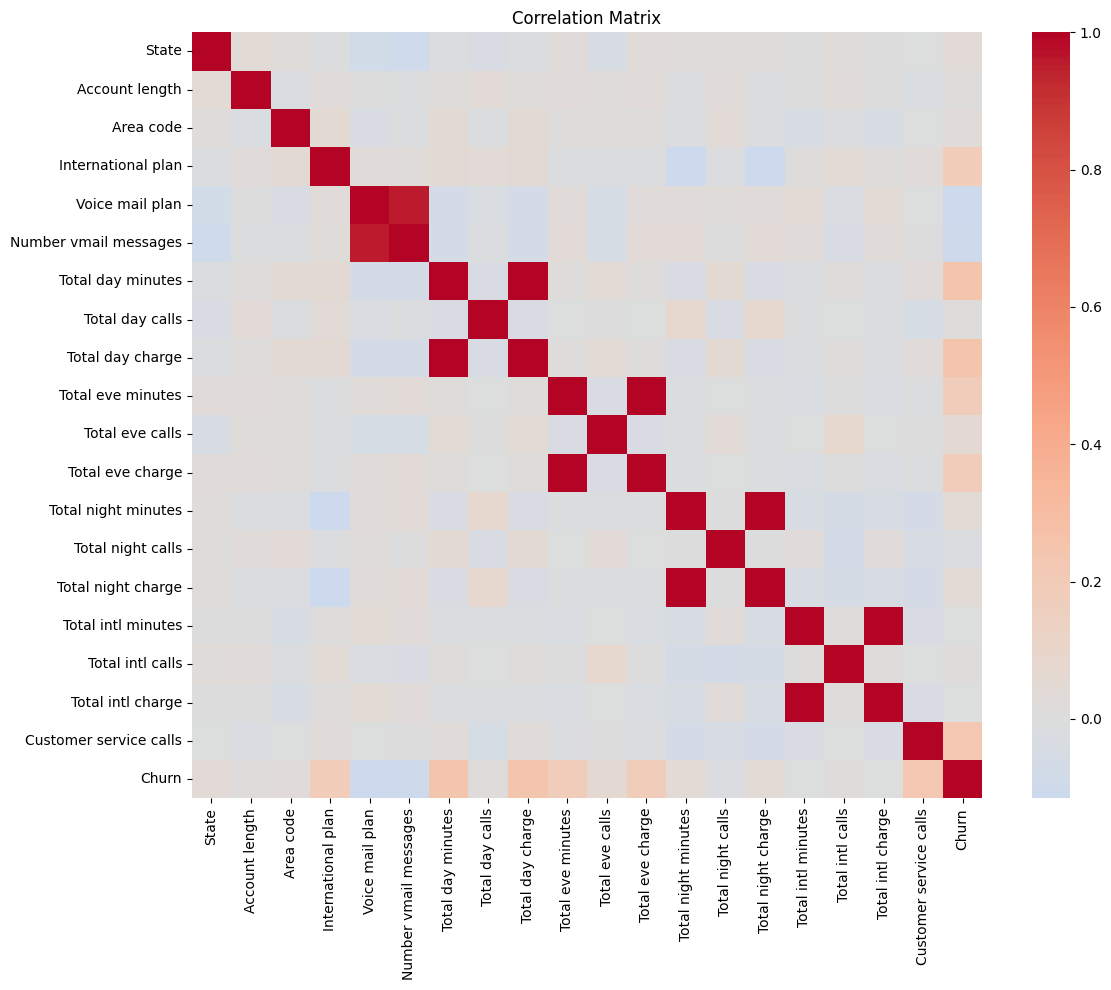

In [8]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

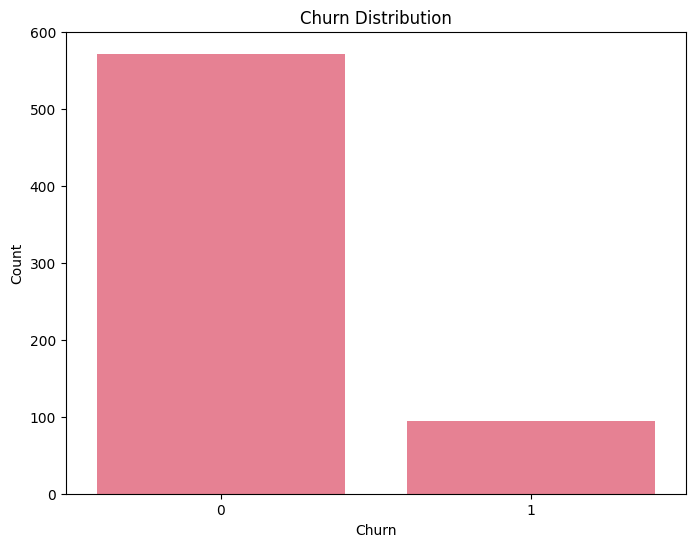

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [9]:
correlation_with_target = df.corr()['Churn'].sort_values(ascending=False)
print("Correlation with Churn:")
print(correlation_with_target)

Correlation with Churn:
Churn                     1.000000
Total day minutes         0.242781
Total day charge          0.242777
Customer service calls    0.233259
International plan        0.181634
Total eve charge          0.175616
Total eve minutes         0.175614
Total eve calls           0.055669
Total night charge        0.042958
Total night minutes       0.042930
State                     0.038488
Area code                 0.027129
Total day calls           0.019360
Total intl calls          0.015331
Account length            0.012315
Total intl charge        -0.003681
Total intl minutes       -0.003740
Total night calls        -0.017626
Number vmail messages    -0.102381
Voice mail plan          -0.113465
Name: Churn, dtype: float64


In [10]:
selected_features = correlation_with_target[abs(correlation_with_target) > 0.05].index.tolist()
selected_features.remove('Churn')  # Remove target variable

X_selected = X[selected_features]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (533, 9)
Test set size: (134, 9)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


Logistic Regression Results:
Accuracy: 0.8433
Precision: 0.2500
Recall: 0.0526
F1-Score: 0.0870

Decision Tree Results:
Accuracy: 0.8955
Precision: 0.6923
Recall: 0.4737
F1-Score: 0.5625

Random Forest Results:
Accuracy: 0.9328
Precision: 0.9167
Recall: 0.5789
F1-Score: 0.7097

Gradient Boosting Results:
Accuracy: 0.9030
Precision: 0.7143
Recall: 0.5263
F1-Score: 0.6061

SVM Results:
Accuracy: 0.9104
Precision: 0.8182
Recall: 0.4737
F1-Score: 0.6000


In [15]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results]
})

print("\nModel Comparison:")
print(metrics_df.sort_values('F1-Score', ascending=False))


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
2        Random Forest  0.932836   0.916667  0.578947  0.709677
3    Gradient Boosting  0.902985   0.714286  0.526316  0.606061
4                  SVM  0.910448   0.818182  0.473684  0.600000
1        Decision Tree  0.895522   0.692308  0.473684  0.562500
0  Logistic Regression  0.843284   0.250000  0.052632  0.086957


In [16]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train with best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_scaled, y_train)
y_pred_best = best_rf.predict(X_test_scaled)

# Evaluate best model
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best)
best_recall = recall_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)

print(f"\nTuned Random Forest Results:")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1-Score: {best_f1:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.6633

Tuned Random Forest Results:
Accuracy: 0.9254
Precision: 0.8462
Recall: 0.5789
F1-Score: 0.6875


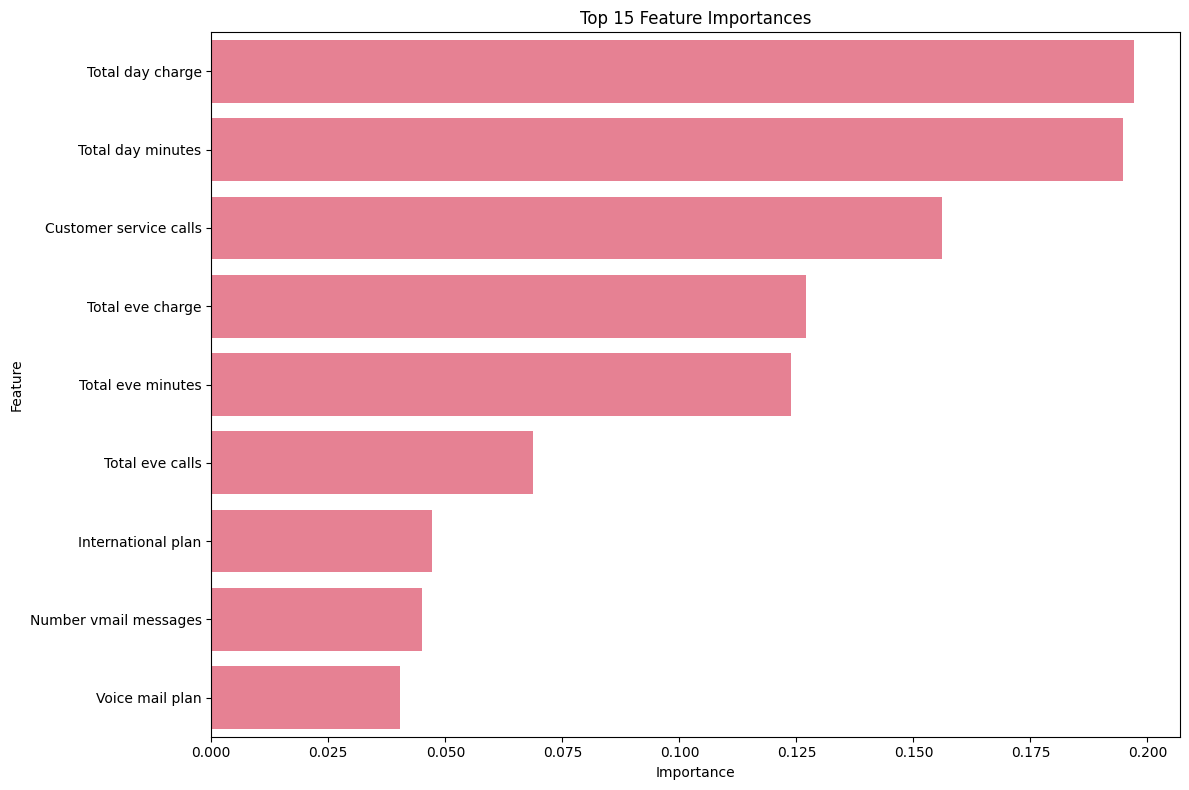

In [17]:
feature_importance = best_rf.feature_importances_
feature_names = X_selected.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

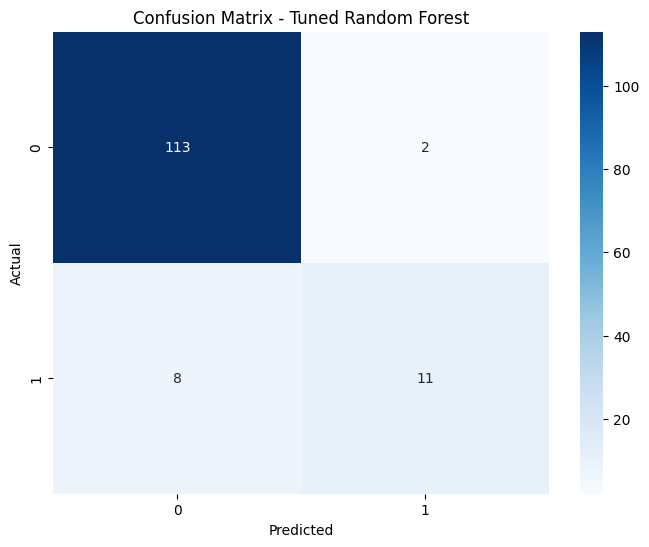

In [18]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       115
           1       0.85      0.58      0.69        19

    accuracy                           0.93       134
   macro avg       0.89      0.78      0.82       134
weighted avg       0.92      0.93      0.92       134



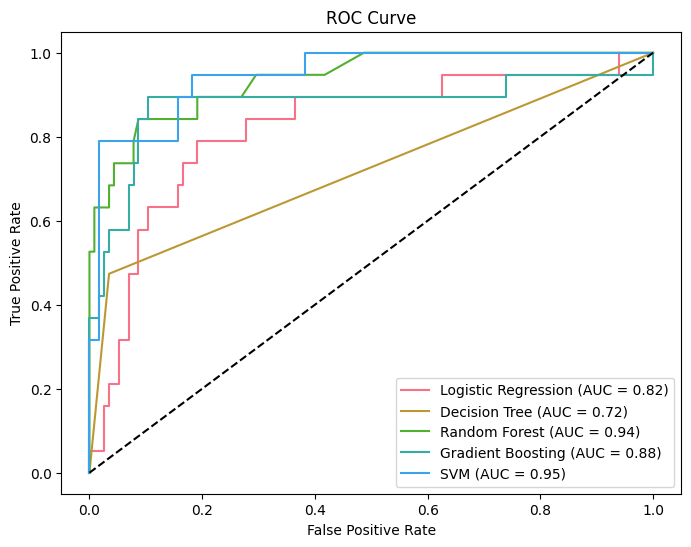

In [20]:
plt.figure(figsize=(8, 6))
for name, result in results.items():
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores}")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross-Validation F1 Scores: [0.58333333 0.63636364 0.66666667 0.81481481 0.61538462]
Mean CV F1 Score: 0.6633 (+/- 0.1610)


In [22]:
final_predictions = best_rf.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, final_predictions)
final_precision = precision_score(y_test, final_predictions)
final_recall = recall_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)

print(f"\nFinal Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")


Final Model Performance:
Accuracy: 0.9254
Precision: 0.8462
Recall: 0.5789
F1-Score: 0.6875


In [23]:
import joblib
joblib.dump(best_rf, 'churn_prediction_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

print("\nModel and preprocessing objects saved successfully!")


Model and preprocessing objects saved successfully!
